In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import torch.nn.functional as F

### 整理数据集

In [4]:
data_dir = os.path.join('.', 'data')

In [6]:
def reorg_dog_data(data_dir, valid_ratio):
    ''' 整理和划分狗图像数据集 '''
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

### 图像增广

In [8]:
# 增加数据多样性，提升模型泛化能力
transform_train = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)), #随机裁剪并缩放到224*224
                                     transforms.RandomHorizontalFlip(), #随机水平翻转，默认概率0.5
                                     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), #数据复杂，加color，随机调整亮度对比度饱和度
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

### Dataset与DataLoader构建

In [10]:
from torch.utils.data import DataLoader

In [12]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                            transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                     transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
                               for dataset in (train_ds, train_valid_ds)]

valid_iter = DataLoader(valid_ds, batch_size, shuffle=False, drop_last=False)

test_iter = DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

### 微调预训练模型

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
def get_net():
    ''' 不改变原来的网络，只是多加了两层 '''
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 120))
    finetune_net = finetune_net.to(device)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

### 计算损失

In [19]:
loss_func = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net):
    ''' 损失计算函数 '''
    total_loss, n = 0.0, 0
    for x, y in data_iter:
        x, y = x.to(device), y.to(device)
        y_hat = net(x)
        loss = loss_func(y_hat, y)
        total_loss += loss.sum()
        n += y.numel()
    return total_loss / n

### 训练函数

In [21]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, lr_period,lr_decay):
    ''' 训练模型 '''
    net = net.to(device)
    trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), 
                              lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (x, y) in enumerate(train_iter):
            timer.start()
            x, y = x.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat, y).sum()
            loss.backward()
            trainer.step()
            metric.add(loss, y.shape[0])
            timer.stop()

            #训练曲线更新
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
                
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()

    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'

    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}')

### 训练和验证模型

train loss 0.984, valid loss 0.799
984.2


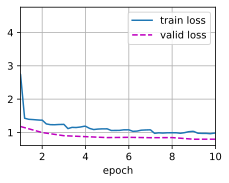

In [23]:
num_epochs, lr, wd = 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, lr_period,
      lr_decay)

train loss 0.988
986.2


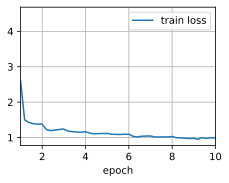

In [25]:
net = get_net()
train(net, train_valid_iter, None, num_epochs, lr, wd, lr_period, lr_decay)

preds = []
for x, y in test_iter:
    y_hat = F.softmax(net(x.to(device)), dim=1) #softmax把输出转为概率
    preds.extend(y_hat.cpu().detach().numpy())
    
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))

with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, y_hat in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in y_hat]) + '\n')